# Lab 7: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"L7_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before 23:59 on December 5, 2018 and put **"AML-L7"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
#sns.set_context('poster')
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both), you can add more methods if needed. Try 10 different random initializations and choose the best one.

In [3]:
class my_NMF():
    
    def __init__(self, n_components, loss='Frobenius', epsilon=1e-4, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        W_: np.array (r,p)
            W Matrix factor
        H_: np.array (n,r)
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        self.history_ = None
        
    def update_W(self, W, H, X):
        """
        
        """
        n = X.shape[0]
        p = X.shape[1]
        r = self.n_components_
        
        if self.loss_=="Frobenius":
            return np.multiply(W, np.divide(H.T@X,H.T@H@W))
            
        elif self.loss_=="KL":
            return np.multiply(np.divide(H.T@np.divide(X, H@W), H.T@np.ones((n,p))), W)
            
        else:
            raise ValueError
        
    def update_H(self, W, H, X):
        """
        
        """
        n = X.shape[0]
        p = X.shape[1]
        r = self.n_components_
        
        if self.loss_=="Frobenius":
            return np.multiply(H, np.divide(X@W.T,H@W@W.T))
            
        elif self.loss_=="KL":
            return np.multiply(np.divide(np.divide(X, H@W)@W.T, np.ones((n,p))@W.T), H)
            
        else:
            raise ValueError
            
    def compute_loss(self, W, H, X):
        """
        
        """
        if self.loss_=="Frobenius":
            return np.linalg.norm(X-H@W, ord='fro')
            
        elif self.loss_=="KL":
            return np.sum(sc.special.kl_div(X,H@W))
            
        else:
            raise ValueError
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n = X.shape[0]
        p = X.shape[1]
        r = self.n_components_

        self.W_ = np.random.rand(r, p)
        self.H_ = np.random.rand(n, r)
        self.error_ = self.compute_loss(self.W_, self.H_, X)
        self.history_ = {
            "W": [self.W_],
            "H": [self.H_],
            "error": [self.error_],
            "converged": False,
            "itr": None
        }

        has_converged = False
        itr = 0
        while not has_converged and itr < self.max_iter_:
            W = self.update_W(self.W_, self.H_, X)
            H = self.update_H(W, self.H_, X)
            
            error = self.compute_loss(W, H, X)
            
            has_converged = abs(error-self.error_) < self.epsilon_
            
            self.W_, self.H_, self.error_ = W, H, error
            
            self.history_["W"].append(W)
            self.history_["H"].append(H)
            self.history_["error"].append(error)
            
            itr += 1
        
        self.history_["converged"] = has_converged
        self.history_["itr"] = itr
        
        return self

**Bonus (not graded)**: Implement the regularized version

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

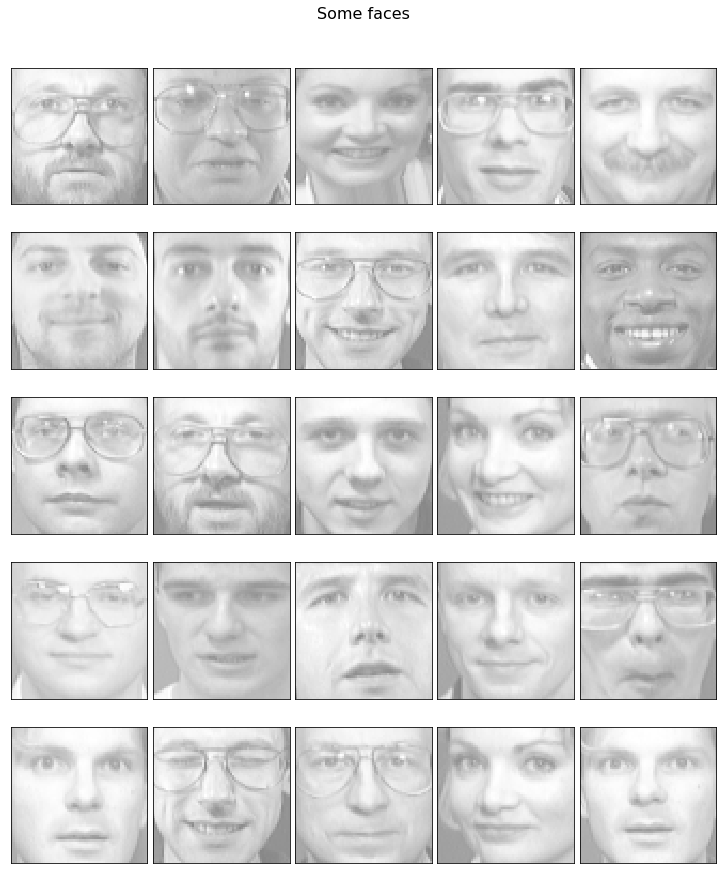

In [43]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray, h=2., w=2.6):
    plt.figure(figsize=(h * n_col, w * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

Apply your NMF algorithm for this dataset and plot the approximated face pictures.

In [58]:
r = 49

# NMF using Frobenius norm
model_f = my_NMF(n_components=r, loss='Frobenius', epsilon=1e-6, max_iter = 500)
model_f.fit_transform(faces)
h_f = model_f.history_

# NMF using KL divergence
model_kl = my_NMF(n_components=r, loss='KL', epsilon=1e-6, max_iter = 500)
model_kl.fit_transform(faces)
h_kl = model_kl.history_

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of both factor matrices.

###### Visualizing a face and its deconstruction or representation

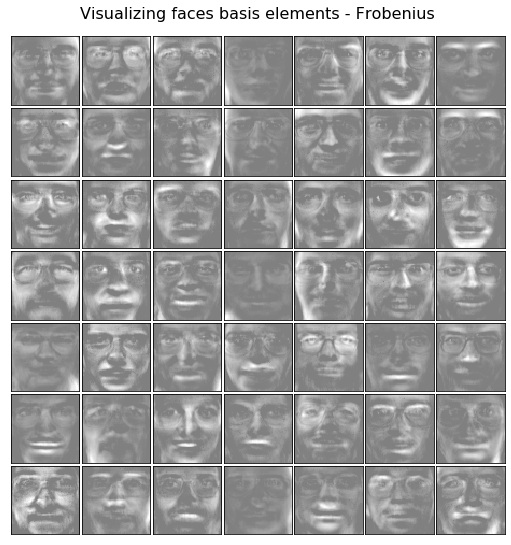

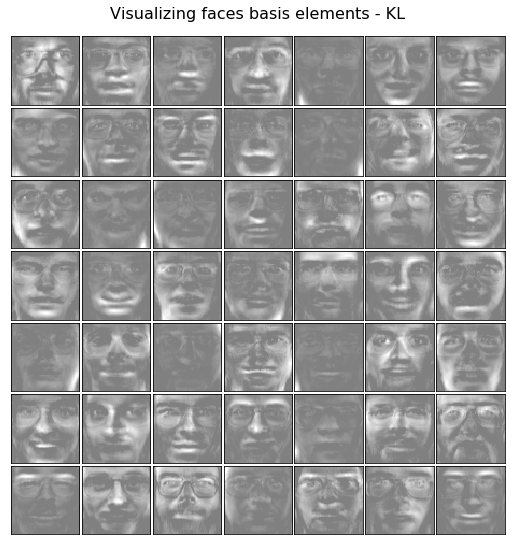

In [59]:
W_f = model_f.W_
W_kl = model_kl.W_
sqrt_r = int(np.sqrt(r))

plot_faces("Visualizing faces basis elements - Frobenius", W_f, image_shape, n_col=sqrt_r, n_row=sqrt_r,
          h=1, w=1.13)
plot_faces("Visualizing faces basis elements - KL", W_kl, image_shape, n_col=sqrt_r, n_row=sqrt_r,
          h=1, w=1.13)

In [64]:
def get_approx(model, index):
    return model.H_[index]@model.W_

def get_weights(model, index):
    return model.H_[index,:]

In [66]:
index = np.random.randint(faces.shape[0])

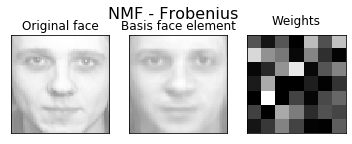

In [67]:
plt.figure(figsize=(2. * 3, 2.26 * 1))
plt.suptitle('NMF - Frobenius', size=16)
cmap=plt.cm.gray
plt.subplot(1, 3, 1)
comp = faces[index]
vmax = max(comp.max(), -comp.min())
plt.imshow(comp.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Original face")
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 2)
comp = get_approx(model_f, index)
vmax = max(comp.max(), -comp.min())
plt.imshow(comp.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Basis face element")
plt.xticks(())
plt.yticks(())

ax = plt.subplot(1, 3, 3)
ax.matshow(get_weights(model_f, index).reshape(sqrt_r, sqrt_r), cmap=cmap)
plt.title("Weights")
plt.xticks(())
plt.yticks(())


plt.show()

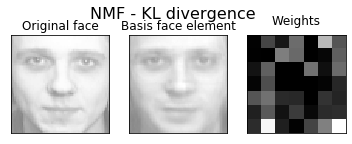

In [68]:
plt.figure(figsize=(2. * 3, 2.26 * 1))
plt.suptitle('NMF - KL divergence', size=16)
cmap=plt.cm.gray
plt.subplot(1, 3, 1)
comp = faces[index]
vmax = max(comp.max(), -comp.min())
plt.imshow(comp.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Original face")
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 2)
comp = get_approx(model_kl, index)
vmax = max(comp.max(), -comp.min())
plt.imshow(comp.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Basis face element")
plt.xticks(())
plt.yticks(())

ax = plt.subplot(1, 3, 3)
ax.matshow(get_weights(model_kl, index).reshape(sqrt_r, sqrt_r), cmap=cmap)
plt.title("Weights")
plt.xticks(())
plt.yticks(())


plt.show()

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with NMF. Print the most common words of each topic.

In [76]:
from sklearn.datasets import fetch_20newsgroups_vectorized
bunch = fetch_20newsgroups_vectorized(subset="all")
data = bunch.data

In [79]:
print(bunch.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [74]:
loc_data = data[:400]
loc_data.shape


array([0.01710965, 0.0342193 , 0.05132894, 0.06843859, 0.08554824,
       0.10265789, 0.13687718, 0.17109648, 0.27375436, 0.3935219 ,
       0.41063155, 0.53039908])

In [9]:
np.array(loc_data)

array(<400x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 58818 stored elements in Compressed Sparse Row format>, dtype=object)

In [10]:
r = 20
model = my_NMF(n_components=r, loss='KL', epsilon=1e-6, max_iter = 60)
model.fit_transform(loc_data.A)

C:\Users\sbran\Anaconda3\envs\aml-tp4\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [ ]:
model.W_